In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
%matplotlib inline

import math

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Train_rev1_2.csv") 
df.head()


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [3]:
df.describe()

,Id,SalaryNormalized
count,2.447680e+05,244768.000000
mean,6.970142e+07,34122.577576
std,3.129813e+06,17640.543124
min,1.261263e+07,5000.000000
25%,6.869550e+07,21500.000000
50%,6.993700e+07,30000.000000
75%,7.162606e+07,42500.000000
max,7.270524e+07,200000.000000


In [4]:
#check missing values
df.isna().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

Text(0.5, 1.0, 'Distribution of Salaries')

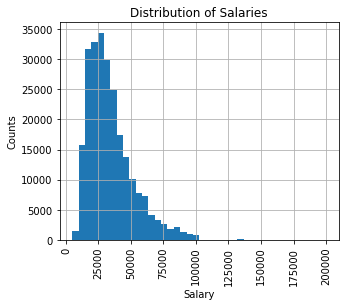

In [5]:
sal_dist = df["SalaryNormalized"]

sal_dist.hist(bins=40, figsize=(5,4))
plt.xlabel('Salary')
plt.xticks(rotation = 90)
plt.ylabel('Counts')
plt.title('Distribution of Salaries')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [7]:
#Turn all string values into category values
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [8]:
#Filling in missing values and perform encoding
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df[label+"is_missing"]=pd.isnull(content)
        # Turn categories into numbers and add+1
        df[label] = pd.Categorical(content).codes+1
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,...,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SalaryRawis_missing,SourceNameis_missing
0,12612628,39227,68301,5178,751,0,2,7758,9,21344,...,False,False,False,False,True,False,False,False,False,False
1,12612830,121388,196351,6881,987,0,2,7758,9,32427,...,False,False,False,False,True,False,False,False,False,False
2,12612844,73486,117824,7630,1069,0,2,7758,9,21539,...,False,False,False,False,True,False,False,False,False,False
3,12613049,39228,68300,17183,2310,0,2,7758,9,31840,...,False,False,False,False,True,False,False,False,False,False
4,12613647,85435,157839,17183,2310,0,2,7758,9,21344,...,False,False,False,False,True,False,False,False,False,False


In [9]:
#check for missing values again
df.isna().sum()

Id                              0
Title                           0
FullDescription                 0
LocationRaw                     0
LocationNormalized              0
ContractType                    0
ContractTime                    0
Company                         0
Category                        0
SalaryRaw                       0
SalaryNormalized                0
SourceName                      0
Titleis_missing                 0
FullDescriptionis_missing       0
LocationRawis_missing           0
LocationNormalizedis_missing    0
ContractTypeis_missing          0
ContractTimeis_missing          0
Companyis_missing               0
Categoryis_missing              0
SalaryRawis_missing             0
SourceNameis_missing            0
dtype: int64

In [10]:
#Train-validation-test split

X = df.drop(columns = ['SalaryNormalized']).copy()
y = df['SalaryNormalized']
# Split the data in training and remaining dataset, train size = 60%
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6)
# Split remaining 50/50 into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(146860, 21)
(146860,)
(48954, 21)
(48954,)
(48954, 21)
(48954,)


(None, None)

In [11]:
#Initialize XGBoost Model
model = xgb.XGBRegressor(objective="reg:squarederror",random_state=42)

In [12]:
#Train basic model
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
#Evaluate the model
y_pred = model.predict(X_valid)
MAE = mean_absolute_error(y_valid,y_pred)
r2 = r2_score(y_valid,y_pred)
print(f'r2 score = {r2}')
print(f'MAE xgboost: {MAE}')


r2 score = 0.8477604878101295
MAE xgboost: 3655.1781505995064


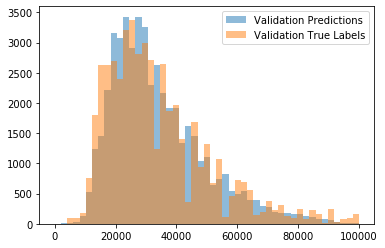

In [14]:
bins = np.linspace(0, 100000, 50)

plt.hist(y_pred, bins, alpha=0.5, label='Validation Predictions')
plt.hist(y_valid, bins, alpha=0.5, label='Validation True Labels')
plt.legend(loc='upper right')
plt.show()

In [15]:
#Tune hyper parameters using Random Search CV
# Takes about 3 minutes
import time

np.random.seed(42)

grid = {
    "n_estimators":np.arange(10,100,10),
    "max_depth":[None,3,5,10],
    "min_child_weight": range(0,50),
    "max_delta_step": range(0,50),
    "reg_alpha": range(0,10),
    "reg_lambda": range(0,10),
    "reg_gamma": range(0,10)
}

rs_model = RandomizedSearchCV(xgb.XGBRegressor(n_jobs=-1, random_state=42),
                              param_distributions = grid,n_iter=5,cv=5,verbose=10,
                             return_train_score = True)
#train rs model

print("Random Search CV search...")
search_time_start = time.time()
rs_model.fit(X_train,y_train)
print("Random Search CV search time:", time.time() - search_time_start)
print('\n')

rs_model.best_params_

Random Search CV search...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START max_delta_step=36, max_depth=3, min_child_weight=48, n_estimators=10, reg_alpha=8, reg_gamma=6, reg_lambda=7
[22:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "reg_gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5; 1/5] END max_delta_step=36, max_depth=3, min_child_weight=48, n_estimators=10, reg_alpha=8, reg_gamma=6, reg_lambda=7;, score=(train=-3.720, test=-3.743) total time=   1.5s
[CV 2/5; 1/5] START max_delta_step=36, max_depth=3, min_child_weight=48, n_estimators=10, reg_alpha=8, reg_gamma=6, reg_lambda=7
[22:01:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Param

[CV 2/5; 3/5] END max_delta_step=31, max_depth=5, min_child_weight=20, n_estimators=30, reg_alpha=2, reg_gamma=8, reg_lambda=2;, score=(train=-3.710, test=-3.597) total time=   2.8s
[CV 3/5; 3/5] START max_delta_step=31, max_depth=5, min_child_weight=20, n_estimators=30, reg_alpha=2, reg_gamma=8, reg_lambda=2
[22:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "reg_gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 3/5; 3/5] END max_delta_step=31, max_depth=5, min_child_weight=20, n_estimators=30, reg_alpha=2, reg_gamma=8, reg_lambda=2;, score=(train=-3.671, test=-3.756) total time=   3.3s
[CV 4/5; 3/5] START max_delta_step=31, max_depth=5, min_child_weight=20, n_estimators=30, reg_alpha=2, reg_gamma=8,

[CV 4/5; 5/5] END max_delta_step=7, max_depth=3, min_child_weight=29, n_estimators=50, reg_alpha=0, reg_gamma=9, reg_lambda=2;, score=(train=-3.723, test=-3.734) total time=   4.7s
[CV 5/5; 5/5] START max_delta_step=7, max_depth=3, min_child_weight=29, n_estimators=50, reg_alpha=0, reg_gamma=9, reg_lambda=2
[22:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "reg_gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 5/5; 5/5] END max_delta_step=7, max_depth=3, min_child_weight=29, n_estimators=50, reg_alpha=0, reg_gamma=9, reg_lambda=2;, score=(train=-3.725, test=-3.724) total time=   5.4s
[22:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "reg_gamma" } might not be u

{'reg_lambda': 2,
 'reg_gamma': 8,
 'reg_alpha': 2,
 'n_estimators': 30,
 'min_child_weight': 20,
 'max_depth': 5,
 'max_delta_step': 31}

In [16]:
rs_model.best_params_

{'reg_lambda': 2,
 'reg_gamma': 8,
 'reg_alpha': 2,
 'n_estimators': 30,
 'min_child_weight': 20,
 'max_depth': 5,
 'max_delta_step': 31}

In [17]:
#Make predictions using best performing model
y_preds_rs = rs_model.predict(X_valid)

In [18]:
#evaluate performance of best performing model
mae_hyp = mean_absolute_error(y_valid,y_preds_rs)
print(f'MAE before H.P. tuning: {MAE} \nMAE after H.P. tuning: {mae_hyp}')
r2 = r2_score(y_valid,y_preds_rs)
print(f'r2 score = {r2}')
#XGBoost with randomized search CV hyper param tuning
#Uses all labels + better missing values approach + better hyper param tuning approach

MAE before H.P. tuning: 3655.1781505995064 
MAE after H.P. tuning: 33778.01990656622
r2 score = -3.6823066925125056


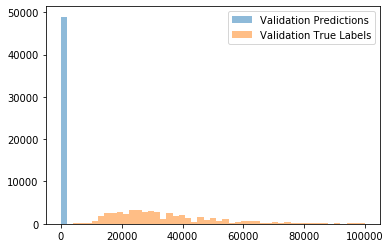

In [19]:
bins = np.linspace(0, 100000, 50)

plt.hist(y_preds_rs, bins, alpha=0.5, label='Validation Predictions')
plt.hist(y_valid, bins, alpha=0.5, label='Validation True Labels')
plt.legend(loc='upper right')
plt.show()

In [20]:
#Final Prediction --> Test Set
test_preds = rs_model.predict(X_test)

In [21]:
#evaluate performance on test set
mae_test = mean_absolute_error(y_test,test_preds)
print(f'MAE on test set = {mae_test}')
r2 = r2_score(y_test,test_preds)
print(f'r2 score = {r2}')


MAE on test set = 33856.51316554403
r2 score = -3.659173597875121


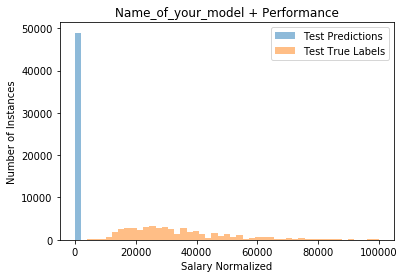

In [22]:

bins = np.linspace(0, 100000, 50)
plt.xlabel('Salary Normalized')
plt.ylabel('Number of Instances')
plt.title('Name_of_your_model + Performance')

plt.hist(test_preds, bins, alpha=0.5, label='Test Predictions')
plt.hist(y_test, bins, alpha=0.5, label='Test True Labels')
plt.legend(loc='upper right')
plt.show()

In [23]:
X_vals = []
[X_vals.append(val) for val in df.columns]
X_vals.remove('SalaryNormalized')
X_vals

['Id',
 'Title',
 'FullDescription',
 'LocationRaw',
 'LocationNormalized',
 'ContractType',
 'ContractTime',
 'Company',
 'Category',
 'SalaryRaw',
 'SourceName',
 'Titleis_missing',
 'FullDescriptionis_missing',
 'LocationRawis_missing',
 'LocationNormalizedis_missing',
 'ContractTypeis_missing',
 'ContractTimeis_missing',
 'Companyis_missing',
 'Categoryis_missing',
 'SalaryRawis_missing',
 'SourceNameis_missing']